# Converting each MOF to a graph
* reads in each MOF from DDEC charge-assigned dataset
* infers bonds using distance-based criterion
* writes to file: 
    * list of crystal names: `list_of_crystals.txt`
    * node features: `graphs/xtalname_node_features.npy`
    * edge list and features: `graphs/xtalname.edge_info`. the edges are 0-based indexed.
    * node labels (charges): `graphs/xtalname_node_labels.npy`
    * location of atom types in one-hot-encoding: `atom_to_int.csv`

In [1]:
using PorousMaterials # use major_refactor branch.
using Base
using DataFrames
using PyPlot
using NPZ
using CSV
using LightGraphs
using LinearAlgebra
using Logging
using Printf
using DelimitedFiles
using ProgressMeter
using PyCall
push!(LOAD_PATH, pwd()) # to see Bonds.jl
using Bonds
using Statistics

# global_logger(Logging.SimpleLogger(stdout, Logging.Info)) # to print @debug put Logging.Debug
global_logger(Logging.SimpleLogger(stdout, Logging.Debug)) # to print @debug put Logging.Debug

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(0x0000002e) open, 0 bytes waiting))), Info, Dict{Any,Int64}())

### get list of MOFs
MOF `.cif` files with DDEC-assigned charges are found in `xtals/`. These were downloaded from [here](https://github.com/gregchung/gregchung.github.io/blob/master/CoRE-MOFs/core-mof-1.0-ddec.tar). The paper corresponding to these structures is [here](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.5b03836).

In [2]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "ddec_xtals")

"/home/sturlusa/my_projects/scratch/mpn_charges/build_graphs/ddec_xtals"

In [3]:
xtalnames = map(x -> replace(x, ".cif" => ""), readdir("ddec_xtals"))

2932-element Array{String,1}:
 "ABAVIJ_clean"
 "ABAVOP_clean"
 "ABEXIQ_clean"
 "ABEXOW_clean"
 "ABEXUC_clean"
 "ABEYAJ_clean"
 "ABEYIR"
 "ABIYIV"
 "ABUWOJ_clean"
 "ACAKUM"
 "ACALIB_clean"
 "ACODED"
 "ACOLIP_clean"
 ⋮
 "ZILBAZ_clean"
 "ZILBED_clean"
 "ZIMJOW_clean"
 "ZISYAD_clean"
 "ZNGLUD01_clean"
 "ZNGLUD_clean"
 "ZURQOS_clean"
 "Zn-DOBDC"
 "ZnBDC"
 "ZnBDCdabco"
 "ZnHBDC"
 "ZnMOF-74"

### Lets remove duplicate structures from the data set.

`duplicates.csv` is a table from Nazarian et al. (DOI: 10.1021/acs.chemmater.5b03836) </br>
Each row contains the names of different `.cif` files of the same structure in the CoRE dataset. </br>
We'll start by cross-referencing the structures in the DDEC dataset with the first column in `duplicates.csv`

In [4]:
all_structures = CSV.read("duplicates.csv")
unique_structures = all_structures[:,1]

4297-element WeakRefStrings.StringArray{String,1}:
 "Cu-BTC"
 "EDUSIF_clean"
 "CIWRAC_clean"
 "GIKMOD01_clean"
 "FIQYOU_clean"
 "ITIWIS_charged"
 "ATIBAG_clean"
 "OKITIM01_charged"
 "FARFIO_clean"
 "IDIWOH"
 "FIJDIM01_clean"
 "MECWEX_manual"
 "BAHGUN01_clean"
 ⋮
 "FALQIU_clean"
 "WAMRIN02_clean"
 "OVEJIJ_clean"
 "UNABIV_charged"
 "ZIF-97"
 "WAWGOQ_clean"
 "IZEPAF_clean"
 "ZIF-93"
 "SAPJEA_charged"
 "DEYNIG_clean"
 "GAHWIX_clean"
 "WENSIS_clean"

In [5]:
set_of_unique_xtals = Set(unique_structures)
set_of_ddec_xtals = Set(xtalnames)
set_of_unique_ddec_xtals = intersect(set_of_unique_xtals, set_of_ddec_xtals)
length(set_of_unique_ddec_xtals)

2285

In some cases, rather than the structure in the first column of `duplicates.csv`, other structures are included in the DDEC dataset. </br>
The following code is used to see if there are other unique structures in the DDEC dataset that were not in the first column of `duplicates.csv`

In [6]:
for (i, unique_xtal) in enumerate(unique_structures)
    if ! in(unique_xtal, set_of_ddec_xtals)
        other_xtals = all_structures[i, 2:end]
        if length(intersect(set_of_ddec_xtals, Set(other_xtals))) > 0
            have_i_added_another_crystal = false
            @warn @sprintf("%s is not in the DDEC set but...\n", unique_xtal)
            for (j, duplicate_xtal) in enumerate(other_xtals)
                if ismissing(duplicate_xtal)
                    break
                end
                if duplicate_xtal in xtalnames
                    if ! have_i_added_another_crystal
                        push!(set_of_unique_ddec_xtals, duplicate_xtal)
                        have_i_added_another_crystal = true
                    end
                    @printf("\t%s is in the set\n", duplicate_xtal)
                end
            end
        end
    end
end

┌ Warning: Cu-BTC is not in the DDEC set but...
└ @ Main In[6]:6
	DOTSOV02_clean is in the set
	DOTSOV03_clean is in the set
	DOTSOV04_clean is in the set
	DOTSOV05_clean is in the set
	DOTSOV06_clean is in the set
	DOTSOV07_clean is in the set
	DOTSOV08_clean is in the set
	DOTSOV09_clean is in the set
	DOTSOV10_clean is in the set
	DOTSOV11_clean is in the set
	DOTSOV12_clean is in the set
	DOTSOV13_clean is in the set
	DOTSOV14_clean is in the set
	DOTSOV15_clean is in the set
	DOTSOV16_clean is in the set
	DOTSOV18_clean is in the set
	DOTSOV19_clean is in the set
	DOTSOV20_clean is in the set
	DOTSOV21_clean is in the set
	DOTSOV22_clean is in the set
	DOTSOV23_clean is in the set
	DOTSOV24_clean is in the set
	DOTSOV25_clean is in the set
	DOTSOV26_clean is in the set
	DOTSOV27_clean is in the set
	DOTSOV28_clean is in the set
	DOTSOV29_clean is in the set
	DOTSOV30_clean is in the set
	DOTSOV31_clean is in the set
	DOTSOV32_clean is in the set
	DOTSOV33_clean is in the set
	DOTS

In [7]:
xtalnames = collect(set_of_unique_ddec_xtals)
@show length(xtalnames);

length(xtalnames) = 2325


### find unique atomic species

In [8]:
unique_atomic_species = Set{Symbol}()

for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif")
    for a in unique(crystal.atoms.species)
        push!(unique_atomic_species, a)
    end
end
unique_atomic_species

println("# unique atomic species: ", length(unique_atomic_species))

# unique atomic species: 74


### analyze occurance of atomic species in MOFs
i.e., how many MOFs contain atom $i$? this is important to ensure we can adequately learn charges on rare MOF atoms.

In [9]:
species_occurance = Dict{Symbol, Int}(a => 0 for a in unique_atomic_species)
for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif")
    for a in unique(crystal.atoms.species)
        species_occurance[a] += 1
    end
end
species_occurance

Dict{Symbol,Int64} with 74 entries:
  :Cl => 70
  :Al => 19
  :Be => 2
  :Re => 5
  :Cr => 16
  :Na => 36
  :Sb => 2
  :Ni => 111
  :S  => 179
  :Ru => 10
  :Tm => 17
  :W  => 14
  :Nd => 78
  :O  => 2050
  :Th => 4
  :F  => 69
  :Co => 237
  :Gd => 64
  :Rh => 2
  :Pu => 1
  :Ca => 39
  :N  => 1472
  :Yb => 25
  :As => 2
  :Se => 1
  ⋮   => ⋮

put in a `DataFrame` for sorting and plotting

In [10]:
df_species_occurance = DataFrame(atom=collect(keys(species_occurance)), 
                                 nb_mofs=collect(values(species_occurance))
                                 )
sort!(df_species_occurance, :nb_mofs)
first(df_species_occurance, 6)

,atom,nb_mofs
,Symbol,Int64
1,Pu,1
2,Se,1
3,Hf,1
4,Ir,1
5,Be,2
6,Sb,2


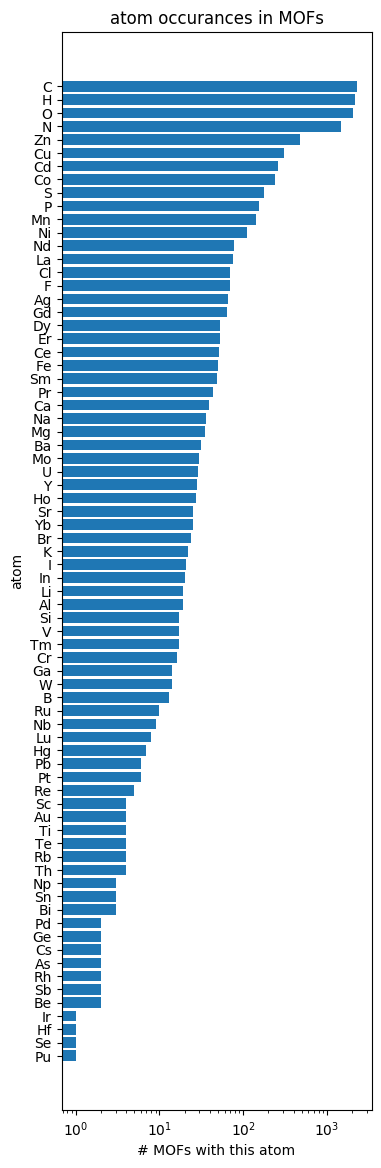

PyObject Text(0.5, 1, 'atom occurances in MOFs')

In [11]:
figure(figsize=(4, 14))
barh(1:nrow(df_species_occurance), df_species_occurance[:, :nb_mofs])
yticks(1:nrow(df_species_occurance), df_species_occurance[:, :atom])
xlabel("# MOFs with this atom")
ylabel("atom")
xscale("log")
title("atom occurances in MOFs")

### atom <--> integer mapping for one-hot encoding

sort my occurance

In [12]:
sort!(df_species_occurance, :nb_mofs, rev=true)
const ATOMS = deepcopy(df_species_occurance[:, :atom])
ATOMS

74-element Array{Symbol,1}:
 :C
 :H
 :O
 :N
 :Zn
 :Cu
 :Cd
 :Co
 :S
 :P
 :Mn
 :Ni
 :Nd
 ⋮
 :Np
 :Be
 :Sb
 :Rh
 :As
 :Cs
 :Ge
 :Pd
 :Pu
 :Se
 :Hf
 :Ir

In [13]:
const ATOM_TO_INT = Dict{Symbol, Int}(a => i for (i, a) in enumerate(ATOMS))
ATOM_TO_INT

Dict{Symbol,Int64} with 74 entries:
  :Cl => 15
  :Al => 39
  :Re => 54
  :Be => 64
  :Cr => 44
  :Na => 26
  :Sb => 65
  :Ni => 12
  :S  => 9
  :Ru => 48
  :Tm => 41
  :W  => 45
  :Nd => 13
  :O  => 3
  :Th => 55
  :F  => 16
  :Co => 8
  :Gd => 18
  :Rh => 66
  :Pu => 71
  :Ca => 25
  :N  => 4
  :Yb => 33
  :As => 67
  :Se => 72
  ⋮   => ⋮

In [14]:
CSV.write(joinpath("..", "atom_to_int.csv"), ATOM_TO_INT)

"../atom_to_int.csv"

### Lets analyze the charges of the DDEC set real quick

In [15]:
charge_list = Dict(atom => Float64[] for atom in keys(ATOM_TO_INT))

for (i_xtal, xtalname) in enumerate(xtalnames)
    xtal = Crystal(xtalname * ".cif", include_zero_charges=true)
    for (j, atom) in enumerate(xtal.atoms.species)
        append!(charge_list[atom], xtal.charges.q[j])
    end
end

In [16]:
atoms = []
σ = []
for x in keys(charge_list)
    push!(atoms, x)
    push!(σ, std(charge_list[x]))
end
stdev_df = DataFrame(Dict(:element => atoms, :stdev => σ))
CSV.write("stdev.csv", stdev_df)

"stdev.csv"

In [17]:
INT_TO_ATOM = Dict(value => key for (key, value) in ATOM_TO_INT)
mean_charges = zeros(length(charge_list))
for i = 1:74
    mean_charges[i] = mean(charge_list[INT_TO_ATOM[i]])
end

In [18]:
mean_charge_df = DataFrame(:mean_charge => mean_charges, :atom => [INT_TO_ATOM[i] for i = 1:74])

,mean_charge,atom
,Float64,Symbol
1,0.0909217,C
2,0.117561,H
3,-0.63384,O
4,-0.303676,N
5,0.940772,Zn
6,0.665301,Cu
7,0.956287,Cd
8,0.933813,Co
9,0.329906,S


In [19]:
mean_charge_dict = Dict()
for row in 1:size(mean_charge_df)[1]
    mean_charge_dict[Symbol(mean_charge_df[!, :atom][row])] = mean_charge_df[!, :mean_charge][row]
end

In [20]:
CSV.write("mean_charges.csv", mean_charge_df)

"mean_charges.csv"

In [21]:
variance_list = Dict([atom => std(charge_list[atom])^2 for atom in keys(charge_list)])

Dict{Symbol,Float64} with 74 entries:
  :Cl => 0.129235
  :Al => 0.0146457
  :Re => 0.0251067
  :Be => 0.000206268
  :Cr => 0.275067
  :Na => 0.00402325
  :Sb => 0.105673
  :Ni => 0.0899525
  :S  => 0.492286
  :Ru => 0.204149
  :Tm => 0.00534872
  :W  => 0.72736
  :Nd => 0.0187538
  :O  => 0.0197265
  :Th => 0.0427729
  :F  => 0.0230854
  :Co => 0.0509429
  :Gd => 0.00800505
  :Rh => 0.113852
  :Pu => 8.025e-11
  :Ca => 0.00289059
  :N  => 0.0482406
  :Yb => 0.0152861
  :As => 0.514185
  :Se => 0.000149378
  ⋮   => ⋮

In [22]:
AD = []

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    new_charge_list = [mean_charge_dict[atom] for atom in crystal.atoms.species]
    variances = [variance_list[atom] for atom in crystal.atoms.species]
    weights = variances ./ sum(variances)
    net_charge = sum(new_charge_list)
    new_charge_list = new_charge_list - net_charge.*weights
    for i in 1:length(new_charge_list)
        push!(AD, abs(new_charge_list[i] - crystal.charges.q[i]))
    end
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


In [23]:
sum(AD)/length(AD)

0.14775732151772583

### write graph structure, edge features, node features, and node labels to file for each MOF

In [24]:
isdir("graphs") ? nothing : mkdir("graphs")

In [25]:
@info "making edge list zero-based indexed for Python"

keep_xtal = [true for i = 1:length(xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("graphs", xtalname * "_node_features.npy"), x_ν)

    ###
    #    node labels (the charges)
    ###
    y_ν = deepcopy(crystal.charges.q)
    npzwrite(joinpath("graphs", xtalname * "_node_labels.npy"), y_ν)
    @assert length(y_ν) == size(x_ν)[1]

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("graphs", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end

writedlm(open("list_of_crystals.txt", "w"), xtalnames[keep_xtal])

┌ Info: making edge list zero-based indexed for Python
└ @ Main In[25]:1


Progress:   4%|█▋                                       |  ETA: 0:08:53

┌ Warning: hydrogen atom 18 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = VAYDOQ_clean.cif
└ @ Main In[25]:23


Progress:   4%|█▊                                       |  ETA: 0:08:48

┌ Warning: hydrogen atom 31 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = BORBEQ_clean.cif
└ @ Main In[25]:23


Progress:   6%|██▋                                      |  ETA: 0:07:49

┌ Warning: hydrogen atom 10 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = BONWIL_clean.cif
└ @ Main In[25]:23


Progress:   7%|██▊                                      |  ETA: 0:07:50

┌ Warning: carbon atom 102 in KOJZAL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:167
┌ Warning: throwing out 
│   crystal.name = KOJZAL_clean.cif
└ @ Main In[25]:23


Progress:   9%|███▊                                     |  ETA: 0:07:25

┌ Warning: hydrogen atom 8 in ISEQIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = ISEQIH_clean.cif
└ @ Main In[25]:23


Progress:  11%|████▌                                    |  ETA: 0:07:34

┌ Warning: hydrogen atom 14 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = FAZZEM_clean.cif
└ @ Main In[25]:23


Progress:  13%|█████▎                                   |  ETA: 0:07:25

┌ Warning: hydrogen atom 17 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = HEZSAG_clean.cif
└ @ Main In[25]:23


Progress:  14%|█████▌                                   |  ETA: 0:07:30

┌ Warning: hydrogen atom 28 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = XAWZOM_clean.cif
└ @ Main In[25]:23


Progress:  16%|██████▋                                  |  ETA: 0:07:19

┌ Warning: carbon atom 29 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:167
┌ Warning: throwing out 
│   crystal.name = MOGXUB_clean.cif
└ @ Main In[25]:23


Progress:  20%|████████▍                                |  ETA: 0:07:12

Voronoi problems with HAFTOZ_clean.cif
┌ Warning: atom 1 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = HAFTOZ_clean.cif
└ @ Main In[25]:23


Progress:  21%|████████▌                                |  ETA: 0:07:08

┌ Warning: carbon atom 109 in NATXOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:167
┌ Warning: throwing out 
│   crystal.name = NATXOW_clean.cif
└ @ Main In[25]:23


Progress:  21%|████████▊                                |  ETA: 0:07:03

┌ Warning: hydrogen atom 5 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = ZERNAN_clean.cif
└ @ Main In[25]:23


Progress:  23%|█████████▎                               |  ETA: 0:06:55

Voronoi problems with COF-5.cif


Progress:  24%|█████████▊                               |  ETA: 0:06:48

Voronoi problems with QUQPOI_clean.cif
┌ Warning: atom 1 = Zn in QUQPOI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = QUQPOI_clean.cif
└ @ Main In[25]:23


Progress:  26%|██████████▌                              |  ETA: 0:06:36

┌ Warning: hydrogen atom 14 in PURQID_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = PURQID_clean.cif
└ @ Main In[25]:23


Progress:  26%|██████████▋                              |  ETA: 0:06:34

┌ Warning: hydrogen atom 6 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = ZERNOB_clean.cif
└ @ Main In[25]:23


Progress:  28%|███████████▌                             |  ETA: 0:06:21

┌ Warning: hydrogen atom 9 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = FIMXUW_clean.cif
└ @ Main In[25]:23


Progress:  35%|██████████████▌                          |  ETA: 0:05:46

┌ Warning: hydrogen atom 10 in SUHHOT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = SUHHOT_clean.cif
└ @ Main In[25]:23


Progress:  38%|███████████████▊                         |  ETA: 0:05:30

┌ Warning: hydrogen atom 16 in UJARAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = UJARAZ_clean.cif
└ @ Main In[25]:23


Progress:  42%|█████████████████▏                       |  ETA: 0:05:08

┌ Warning: carbon atom 89 in HITXUE.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:167
┌ Warning: throwing out 
│   crystal.name = HITXUE.cif
└ @ Main In[25]:23


Progress:  45%|██████████████████▌                      |  ETA: 0:04:48

┌ Warning: hydrogen atom 11 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = UXABUR_clean.cif
└ @ Main In[25]:23


Progress:  45%|██████████████████▌                      |  ETA: 0:04:47

Voronoi problems with DUXZIG01_clean.cif
┌ Warning: atom 1 = Zn in DUXZIG01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = DUXZIG01_clean.cif
└ @ Main In[25]:23


Progress:  46%|███████████████████                      |  ETA: 0:04:43

┌ Warning: atom 23 = H in JEMQEY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = JEMQEY_clean.cif
└ @ Main In[25]:23


Progress:  49%|████████████████████▎                    |  ETA: 0:04:28

┌ Warning: hydrogen atom 17 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = TEWGEJ01_clean.cif
└ @ Main In[25]:23


Progress:  50%|████████████████████▍                    |  ETA: 0:04:28

┌ Warning: carbon atom 125 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:167
┌ Warning: throwing out 
│   crystal.name = WAZQUL_clean.cif
└ @ Main In[25]:23


Progress:  50%|████████████████████▍                    |  ETA: 0:04:27

Voronoi problems with KECRAL10_clean.cif
┌ Warning: atom 1 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = KECRAL10_clean.cif
└ @ Main In[25]:23


Progress:  50%|████████████████████▌                    |  ETA: 0:04:25

┌ Warning: hydrogen atom 9 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = VASKOR_clean.cif
└ @ Main In[25]:23


Progress:  50%|████████████████████▋                    |  ETA: 0:04:23

┌ Warning: carbon atom 125 in WAZRAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:167
┌ Warning: throwing out 
│   crystal.name = WAZRAS_clean.cif
└ @ Main In[25]:23


Progress:  51%|█████████████████████                    |  ETA: 0:04:18

┌ Warning: carbon atom 27 in YEWWUU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:167
┌ Warning: throwing out 
│   crystal.name = YEWWUU_clean.cif
└ @ Main In[25]:23


Progress:  54%|██████████████████████                   |  ETA: 0:04:06

┌ Warning: atom 81 = O in NAJGAH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = NAJGAH_clean.cif
└ @ Main In[25]:23


Progress:  54%|██████████████████████                   |  ETA: 0:04:05

┌ Warning: hydrogen atom 5 in ZERNUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = ZERNUH_clean.cif
└ @ Main In[25]:23


Progress:  57%|███████████████████████▌                 |  ETA: 0:03:46

┌ Warning: hydrogen atom 36 in WENKEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = WENKEH_clean.cif
└ @ Main In[25]:23


Progress:  61%|████████████████████████▉                |  ETA: 0:03:29

┌ Warning: carbon atom 79 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:167
┌ Warning: throwing out 
│   crystal.name = MOGYAI_clean.cif
└ @ Main In[25]:23


Progress:  61%|█████████████████████████                |  ETA: 0:03:27

┌ Warning: hydrogen atom 20 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = QARTEK_clean.cif
└ @ Main In[25]:23


Progress:  65%|██████████████████████████▌              |  ETA: 0:03:10

┌ Warning: carbon atom 23 in LIQGEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:167
┌ Warning: throwing out 
│   crystal.name = LIQGEY_clean.cif
└ @ Main In[25]:23


Progress:  67%|███████████████████████████▌             |  ETA: 0:02:57

┌ Warning: hydrogen atom 10 in PAMHES01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = PAMHES01_clean.cif
└ @ Main In[25]:23


Progress:  68%|███████████████████████████▉             |  ETA: 0:02:52

┌ Warning: hydrogen atom 5 in PAMGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = PAMGIV_clean.cif
└ @ Main In[25]:23


Progress:  74%|██████████████████████████████▌          |  ETA: 0:02:18

┌ Warning: hydrogen atom 7 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = QOPHEI_clean.cif
└ @ Main In[25]:23


Progress:  75%|██████████████████████████████▉          |  ETA: 0:02:13

┌ Warning: hydrogen atom 7 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = LETRIN_clean.cif
└ @ Main In[25]:23


Progress:  77%|███████████████████████████████▋         |  ETA: 0:02:02

┌ Warning: hydrogen atom 10 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = BEXTUV_clean.cif
└ @ Main In[25]:23


Progress:  79%|████████████████████████████████▍        |  ETA: 0:01:52

Voronoi problems with FUNCEX_clean.cif
┌ Warning: atom 1 = Zn in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = FUNCEX_clean.cif
└ @ Main In[25]:23


Progress:  79%|████████████████████████████████▌        |  ETA: 0:01:51

Voronoi problems with TEDGOA_clean.cif
┌ Warning: atom 1 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = TEDGOA_clean.cif
└ @ Main In[25]:23


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:01:11

┌ Warning: atom 285 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = RIDKOE.cif
└ @ Main In[25]:23


Progress:  87%|███████████████████████████████████▉     |  ETA: 0:01:08

Voronoi problems with FUNBOG_clean.cif
┌ Warning: atom 1 = Zn in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = FUNBOG_clean.cif
└ @ Main In[25]:23


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:56

┌ Warning: hydrogen atom 9 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = OXAZIX_clean.cif
└ @ Main In[25]:23


Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:52

┌ Warning: atom 35 = H in RUVMAX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = RUVMAX_clean.cif
└ @ Main In[25]:23


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:49

┌ Warning: hydrogen atom 9 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = VEHRIL_clean.cif
└ @ Main In[25]:23


Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:46

┌ Warning: hydrogen atom 35 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = UDANAQ_clean.cif
└ @ Main In[25]:23


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:33

┌ Warning: atom 129 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = ZEKROY.cif
└ @ Main In[25]:23


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:22

┌ Warning: hydrogen atom 49 in NEVGIE.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = NEVGIE.cif
└ @ Main In[25]:23


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:07

┌ Warning: hydrogen atom 10 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:162
┌ Warning: throwing out 
│   crystal.name = ASALIP_clean.cif
└ @ Main In[25]:23


Progress: 100%|█████████████████████████████████████████| Time: 0:09:00


In [26]:
length(keep_xtal)

2325

In [27]:
println("threw out ", sum(.! keep_xtal), )

threw out 50


In [28]:
f = open("list_of_crystals.txt", "w")
writedlm(f, xtalnames[keep_xtal])
close(f)

# viz an example structure

In [29]:
xtal = "ALUKIC_clean.cif"
xtal = Crystal(xtal)
write_vtk(xtal, center_at_origin=true)

xtal = replicate(xtal, (1, 1, 1))

try
    bonds!(xtal, true)
catch e
    if isa(e, PyCall.PyError)
        remove_bonds!(xtal) # some of the bonds were probz formed
        println("Voronoi problems with " * xtal.name)
        infer_bonds!(xtal, true) # infer bonds with old distance-based version
    else
        error("bond! error for " * xtal.name)
    end
end

if ! is_connected(xtal.bonds)
    println("not connected")
end

write_xyz(xtal, center_at_origin=true)
write_bond_information(xtal, center_at_origin=true)

See ALUKIC_clean.vtk
Saving bond information for crystal ALUKIC_clean.cif to /home/sturlusa/my_projects/scratch/mpn_charges/build_graphs/ALUKIC_clean_bonds.vtk.


# Deployment Sets (ASR and FSR)

In [ ]:
for subset in ["ASR", "FSR"]
    xtal_path = "CoRE_v2_" * subset
    @eval PorousMaterials PATH_TO_CRYSTALS = $(Meta.quot(joinpath(pwd(), xtal_path)))
    xtalnames = map(x -> replace(x, ".cif" => ""), readdir("CoRE_v2_" * subset))
    isdir("deployment_graphs_" * subset) ? nothing : mkdir("deployment_graphs_" * subset)
    
    keep_xtal = [true for i = 1:length(xtalnames)]

    for (i_xtal, xtalname) in enumerate(xtalnames)
        crystal = Crystal(xtalname * ".cif", include_zero_charges=true, check_overlap=false, check_neutrality=false)
        strip_numbers_from_atom_labels!(crystal)
        if ! all([atom_species in keys(ATOM_TO_INT) for atom_species in crystal.atoms.species])
            keep_xtal[i_xtal] = false
            continue
        end

        unique_atoms = unique(crystal.atoms.species)
        if any([unique_atom in [:Hf, :Se, :Ir, :Pu, :Cs] for unique_atom in unique_atoms])
            keep_xtal[i_xtal] = false
            continue
        end

        try
            bonds!(crystal, true)
        catch e
            if isa(e, PyCall.PyError)
                remove_bonds!(crystal) # some of the bonds were probz formed
                println("Voronoi problems with " * crystal.name)
                infer_bonds!(crystal, true) # infer bonds with old distance-based version
            else
                error("bond! error for " * crystal.name)
            end
        end
        if nv(crystal.bonds) != crystal.atoms.n
            keep_xtal[i_xtal] = false
            @warn "throwing out " crystal.name
            continue
        end

        if ! PorousMaterials.bond_sanity_check(crystal)
            keep_xtal[i_xtal] = false
            @warn "throwing out " crystal.name
            continue
        end

        x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
        for (i, atom) in enumerate(crystal.atoms.species)
            x_ν[i, ATOM_TO_INT[atom]] = 1
        end
        @assert sum(x_ν) == crystal.atoms.n
        npzwrite(joinpath("deployment_graphs_" * subset, xtalname * "_node_features.npy"), x_ν)

        ###
        #   edges
        #   (a list and their feature = distance btwn atoms)
        ###
        edge_file = open(joinpath("deployment_graphs_" * subset, xtalname * ".edge_info"), "w")
        @printf(edge_file, "src,dst,r\n")
        for ed in edges(crystal.bonds)
            i = src(ed) # source
            j = dst(ed) # destination
            r = distance(crystal.atoms, crystal.box, i, j, true)
            @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
        end
        close(edge_file)
    end

    writedlm(open("list_of_" * subset * "_deployment_crystals.txt", "w"), xtalnames[keep_xtal])
end

┌ Warning: atom 273 = Cl in ADOBAX_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = ADOBAX_charged.cif
└ @ Main In[30]:42
┌ Warning: atom 273 = Cl in ADOBEB_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = ADOBEB_charged.cif
└ @ Main In[30]:42
┌ Warning: atom 273 = Cl in ADOBOL_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = ADOBOL_charged.cif
└ @ Main In[30]:42
┌ Warning: atom 273 = F in ADOBUR_charged.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:157
┌ Warning: throwing out 
│   crystal.name = ADOBUR_charged.cif
└ @ Main In[30]:42
┌ Warning: hydrogen a